# 2D Grouped Convex Hull Algorithm — Animation

This notebook demonstrates a **grouped convex hull** algorithm in 2D:

1. **Grouping phase**: Divide $n$ points into groups of size $m = 2^{2^i}$ at level $i$, compute local convex hulls per group.
2. **Gift Wrapping (Jarvis March) phase**: Starting from a known extreme point, iteratively find the next hull edge by querying each group's local hull for the best tangent, then picking the overall best.

Two animations are provided:
- **Animation 1** — Grouping & local hull construction (step-by-step)
- **Animation 2** — Gift wrapping: from each current edge, show candidate evaluation across groups and selection of the next hull vertex

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import FancyArrowPatch, Polygon
from scipy.spatial import ConvexHull
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

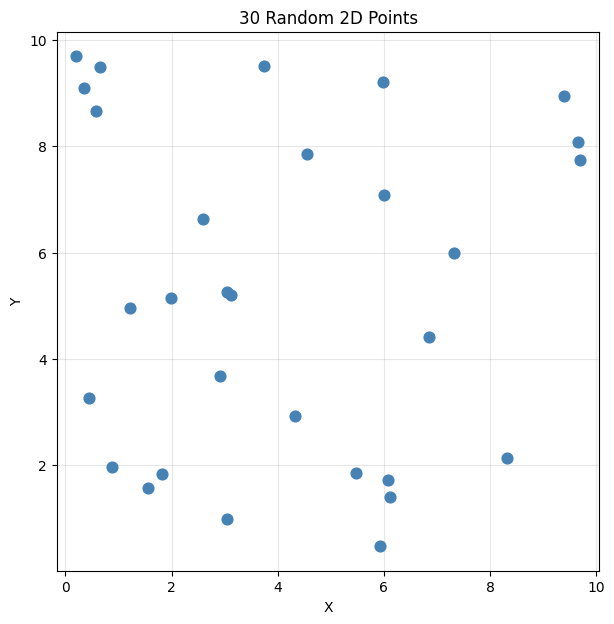

In [4]:
# ============================================
# Generate random 2D points
# ============================================
np.random.seed(42)
n_points = 30
points = np.random.rand(n_points, 2) * 10  # scale to [0, 10]

plt.figure(figsize=(7, 7))
plt.scatter(points[:, 0], points[:, 1], s=60, c='steelblue', zorder=5)
plt.title(f'{n_points} Random 2D Points')
plt.xlabel('X'); plt.ylabel('Y')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

In [5]:
# ============================================
# Core: Grouped Convex Hull helpers
# ============================================

def cross2d(o, a, b):
    """2D cross product of vectors OA and OB (positive = counter-clockwise)."""
    return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])

def local_hull_vertices(pts):
    """Return the convex hull vertex indices (CCW order) for a 2D point set."""
    if len(pts) < 3:
        return list(range(len(pts)))
    try:
        hull = ConvexHull(pts)
        # ConvexHull.vertices are already in CCW order for 2D
        return list(hull.vertices)
    except Exception:
        return list(range(len(pts)))

def tangent_from_point_to_hull(p, hull_pts, hull_verts):
    """
    Given a query point p (not inside the hull) and a convex polygon
    (hull_pts[hull_verts] in CCW order), return the vertex index (into hull_pts)
    that maximises the left-turn angle from p — i.e. the next CCW candidate
    for gift wrapping.
    """
    best_idx = hull_verts[0]
    for v in hull_verts[1:]:
        # If hull_pts[v] is "more counter-clockwise" from p than best, update
        if cross2d(p, hull_pts[best_idx], hull_pts[v]) < 0:
            best_idx = v
    return best_idx

print("Helpers defined ✓")

Helpers defined ✓


## Animation 1 — Grouping & Local Hull Construction

Points are divided into groups of size $m = 2^{2^{\text{level}}}$.  
For each group a local convex hull is computed.  
The animation shows groups appearing one by one with their local hulls.

In [6]:
# ============================================
# Animation 1: Grouping & Local Hull Construction
# ============================================

def create_grouping_animation(points, level=1):
    """Animate grouping of points and local hull computation."""
    n = len(points)
    m = 2 ** (2 ** level)                    # group size
    num_groups = int(np.ceil(n / m))
    
    # Prepare group data
    group_data = []
    for j in range(num_groups):
        s, e = j * m, min((j + 1) * m, n)
        gp = points[s:e]
        hv = local_hull_vertices(gp)
        group_data.append({'points': gp, 'hull_verts': hv, 'start': s, 'end': e})

    colors = plt.cm.tab10(np.linspace(0, 1, max(num_groups, 1)))

    # Frames: 0 = all points grey, 1..num_groups = each group appears,
    # num_groups+1 = final view with all hulls
    total_frames = num_groups + 2

    fig, ax = plt.subplots(figsize=(8, 8))

    def update(frame):
        ax.clear()
        ax.set_xlim(points[:, 0].min() - 1, points[:, 0].max() + 1)
        ax.set_ylim(points[:, 1].min() - 1, points[:, 1].max() + 1)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.2)

        if frame == 0:
            # Show all points in grey
            ax.scatter(points[:, 0], points[:, 1], c='grey', s=50, alpha=0.5, zorder=3)
            ax.set_title(f'Level {level}: m = {m},  {num_groups} groups\n(all points)', fontsize=13)
            return

        groups_to_show = min(frame, num_groups)

        # Dim unassigned points
        if groups_to_show < num_groups:
            remaining_start = group_data[groups_to_show]['start']
            ax.scatter(points[remaining_start:, 0], points[remaining_start:, 1],
                       c='grey', s=30, alpha=0.25, zorder=2)

        for j in range(groups_to_show):
            gd = group_data[j]
            gp = gd['points']
            hv = gd['hull_verts']
            c = colors[j]
            is_current = (j == groups_to_show - 1) and (frame <= num_groups)

            # Points
            ax.scatter(gp[:, 0], gp[:, 1], color=c, s=70 if is_current else 50,
                       zorder=5, edgecolors='black' if is_current else 'none',
                       linewidths=1.5 if is_current else 0)

            # Hull polygon
            hull_pts = gp[hv]
            hull_closed = np.vstack([hull_pts, hull_pts[0]])
            ax.fill(hull_pts[:, 0], hull_pts[:, 1], color=c, alpha=0.12)
            ax.plot(hull_closed[:, 0], hull_closed[:, 1], color=c,
                    linewidth=2.5 if is_current else 1.5, zorder=4)

            # Label
            centroid = gp.mean(axis=0)
            ax.text(centroid[0], centroid[1], f'G{j}', fontsize=11, fontweight='bold',
                    ha='center', va='center', color=c,
                    bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7))

        if frame <= num_groups:
            ax.set_title(f'Level {level}: Adding Group {groups_to_show - 1}  '
                         f'({len(group_data[groups_to_show - 1]["points"])} pts)',
                         fontsize=13)
        else:
            ax.set_title(f'Level {level}: All {num_groups} groups with local hulls', fontsize=13)

    anim = FuncAnimation(fig, update, frames=total_frames, interval=900, repeat=True)
    plt.close(fig)
    return anim

# --- Run ---
anim_grouping = create_grouping_animation(points, level=1)
display(HTML(anim_grouping.to_jshtml()))
print("Grouping animation created ✓")

Grouping animation created ✓


## Animation 2 — Gift Wrapping with Group Tangent Queries

Starting from the leftmost point, the algorithm wraps around the hull:

1. **Red point + blue line**: current point and the direction we're sweeping from  
2. **Gold arrows**: tangent query to each group's local hull → candidate next vertex  
3. **Green star + thick green edge**: the overall best candidate is selected as the next hull vertex  
4. **Grey edges**: previously confirmed hull edges

In [7]:
# ============================================
# Animation 2: Gift Wrapping (Jarvis March) with
#   per-group tangent queries
# ============================================

def run_grouped_gift_wrap(points, level=1):
    """
    Execute grouped gift-wrap and record every step for animation.
    Returns (hull_order, step_records, group_data).
    """
    n = len(points)
    m = 2 ** (2 ** level)
    num_groups = int(np.ceil(n / m))

    # Build groups & local hulls
    group_data = []
    for j in range(num_groups):
        s, e = j * m, min((j + 1) * m, n)
        gp = points[s:e]
        hv = local_hull_vertices(gp)
        group_data.append({
            'points': gp, 'hull_verts': hv,
            'start': s, 'end': e,
            'global_hull_verts': [s + v for v in hv]
        })

    # Start from the leftmost point (guaranteed on hull)
    start_idx = int(np.argmin(points[:, 0]))
    current = start_idx
    hull_order = [current]
    steps = []

    for _ in range(n):
        # Query each group for the best candidate
        prev_pt = points[current]
        group_candidates = []
        overall_best = None

        for g_idx, gd in enumerate(group_data):
            # Find best vertex inside this group's hull
            gp = gd['points']
            ghv = gd['hull_verts']
            offset = gd['start']

            best_local = None
            for lv in ghv:
                gv = offset + lv          # global index
                if gv == current:
                    continue
                if overall_best is None:
                    best_local = gv
                    overall_best = gv
                else:
                    if cross2d(prev_pt, points[overall_best], points[gv]) < 0:
                        overall_best = gv
                    # Also track per-group best for animation
                if best_local is None:
                    best_local = gv
                else:
                    if cross2d(prev_pt, points[best_local], points[gv]) < 0:
                        best_local = gv

            if best_local is not None:
                group_candidates.append({
                    'group': g_idx,
                    'candidate_global': best_local,
                    'candidate_pt': points[best_local].copy()
                })

        # Re-pick global best across group candidates
        overall_best = group_candidates[0]['candidate_global']
        for gc in group_candidates[1:]:
            if cross2d(prev_pt, points[overall_best], points[gc['candidate_global']]) < 0:
                overall_best = gc['candidate_global']

        steps.append({
            'current': current,
            'current_pt': prev_pt.copy(),
            'group_candidates': group_candidates,
            'best_global': overall_best,
            'best_pt': points[overall_best].copy(),
            'hull_so_far': list(hull_order)
        })

        current = overall_best
        hull_order.append(current)
        if current == start_idx:
            break

    return hull_order, steps, group_data


def create_wrapping_animation(points, level=1):
    """Create gift-wrapping animation with per-group tangent queries."""
    hull_order, steps, group_data = run_grouped_gift_wrap(points, level)
    num_groups = len(group_data)
    colors = plt.cm.tab10(np.linspace(0, 1, max(num_groups, 1)))

    # 3 sub-frames per step:
    #   0 — show current point & direction
    #   1 — show group candidates
    #   2 — select best, draw new edge
    total_frames = len(steps) * 3 + 1  # +1 for final complete hull

    pad = 1
    x_lo, x_hi = points[:, 0].min() - pad, points[:, 0].max() + pad
    y_lo, y_hi = points[:, 1].min() - pad, points[:, 1].max() + pad

    fig, ax = plt.subplots(figsize=(9, 9))

    def draw_base(ax):
        """Draw groups dimmed + local hulls."""
        for g_idx, gd in enumerate(group_data):
            gp = gd['points']
            hv = gd['hull_verts']
            c = colors[g_idx]
            ax.scatter(gp[:, 0], gp[:, 1], color=c, s=35, alpha=0.35, zorder=2)
            hull_pts = gp[hv]
            hull_closed = np.vstack([hull_pts, hull_pts[0]])
            ax.fill(hull_pts[:, 0], hull_pts[:, 1], color=c, alpha=0.06)
            ax.plot(hull_closed[:, 0], hull_closed[:, 1], color=c,
                    linewidth=1, alpha=0.4, zorder=2)

    def update(frame):
        ax.clear()
        ax.set_xlim(x_lo, x_hi)
        ax.set_ylim(y_lo, y_hi)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.15)

        draw_base(ax)

        if frame >= len(steps) * 3:
            # Final frame — complete hull
            for i in range(len(hull_order) - 1):
                pi, pj = points[hull_order[i]], points[hull_order[i + 1]]
                ax.plot([pi[0], pj[0]], [pi[1], pj[1]], 'g-', linewidth=2.5, zorder=6)
            hv_pts = points[[h for h in hull_order[:-1]]]
            ax.scatter(hv_pts[:, 0], hv_pts[:, 1], c='green', s=100,
                       marker='o', edgecolors='darkgreen', linewidths=1.5, zorder=7)
            ax.set_title('Gift Wrapping Complete!', fontsize=14, fontweight='bold')
            return

        step_idx = frame // 3
        sub = frame % 3
        step = steps[step_idx]
        cur_pt = step['current_pt']

        # Draw already-confirmed hull edges (grey)
        hsf = step['hull_so_far']
        for i in range(len(hsf) - 1):
            pi, pj = points[hsf[i]], points[hsf[i + 1]]
            ax.plot([pi[0], pj[0]], [pi[1], pj[1]], color='grey',
                    linewidth=2, zorder=4)
        # Confirmed hull vertices
        if len(hsf) > 1:
            hv_pts = points[hsf]
            ax.scatter(hv_pts[:, 0], hv_pts[:, 1], c='grey', s=70,
                       edgecolors='dimgrey', linewidths=1, zorder=5)

        # Current point (red)
        ax.scatter(*cur_pt, c='red', s=180, marker='o', edgecolors='darkred',
                   linewidths=2, zorder=8)
        ax.annotate('current', cur_pt, textcoords='offset points',
                    xytext=(8, 10), fontsize=10, color='red', fontweight='bold')

        title = f'Step {step_idx + 1}/{len(steps)}'

        if sub >= 1:
            # Show group candidates with arrows
            for gc in step['group_candidates']:
                g = gc['group']
                cpt = gc['candidate_pt']
                c = colors[g]
                # Arrow from current to candidate
                ax.annotate('', xy=cpt, xytext=cur_pt,
                            arrowprops=dict(arrowstyle='->', color=c,
                                            lw=2, linestyle='--'))
                ax.scatter(*cpt, c='gold', s=160, marker='*', edgecolors='orange',
                           linewidths=1, zorder=9)
                ax.annotate(f'G{g}', cpt, textcoords='offset points',
                            xytext=(6, 6), fontsize=9, color=c, fontweight='bold')
            title += '  —  querying group tangents'

        if sub >= 2:
            # Highlight the winner
            bp = step['best_pt']
            ax.scatter(*bp, c='lime', s=350, marker='*', edgecolors='darkgreen',
                       linewidths=2, zorder=10)
            ax.plot([cur_pt[0], bp[0]], [cur_pt[1], bp[1]], color='green',
                    linewidth=3, zorder=9)
            # Find which group it belongs to
            best_g = None
            for gc in step['group_candidates']:
                if gc['candidate_global'] == step['best_global']:
                    best_g = gc['group']
                    break
            title += f'\n✓ Best from Group {best_g}'
        elif sub == 0:
            title += '  —  current vertex'

        ax.set_title(title, fontsize=13)

    anim = FuncAnimation(fig, update, frames=total_frames, interval=800, repeat=True)
    plt.close(fig)
    return anim, hull_order, steps, group_data

# --- Run ---
anim_wrap, hull_order, steps, group_data = create_wrapping_animation(points, level=1)
display(HTML(anim_wrap.to_jshtml()))
print(f"Gift wrapping animation: {len(steps)} steps, hull has {len(hull_order)-1} vertices ✓")

Gift wrapping animation: 11 steps, hull has 11 vertices ✓


## Static Summary — Groups + Final Hull

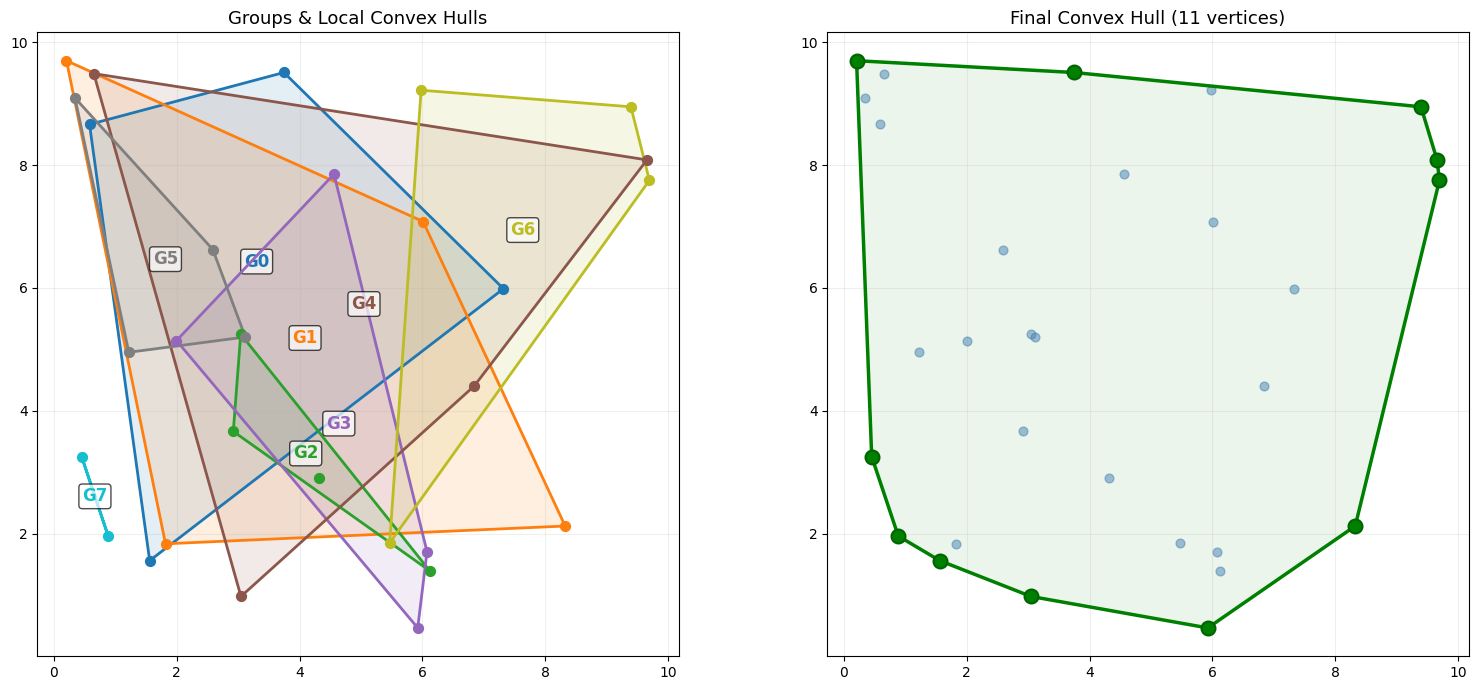

Summary plot complete ✓


In [8]:
# ============================================
# Static overview: groups + final hull overlay
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
colors = plt.cm.tab10(np.linspace(0, 1, max(len(group_data), 1)))

# Left: groups with local hulls
ax = axes[0]
for g_idx, gd in enumerate(group_data):
    gp = gd['points']
    hv = gd['hull_verts']
    c = colors[g_idx]
    ax.scatter(gp[:, 0], gp[:, 1], color=c, s=50, zorder=4)
    hp = gp[hv]
    hc = np.vstack([hp, hp[0]])
    ax.fill(hp[:, 0], hp[:, 1], color=c, alpha=0.12)
    ax.plot(hc[:, 0], hc[:, 1], color=c, linewidth=2, zorder=3)
    centroid = gp.mean(axis=0)
    ax.text(centroid[0], centroid[1], f'G{g_idx}', fontsize=12,
            fontweight='bold', ha='center', va='center', color=c,
            bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7))
ax.set_title('Groups & Local Convex Hulls', fontsize=13)
ax.set_aspect('equal'); ax.grid(True, alpha=0.2)

# Right: final global hull
ax = axes[1]
ax.scatter(points[:, 0], points[:, 1], c='steelblue', s=40, alpha=0.5, zorder=3)
for i in range(len(hull_order) - 1):
    pi, pj = points[hull_order[i]], points[hull_order[i + 1]]
    ax.plot([pi[0], pj[0]], [pi[1], pj[1]], 'g-', linewidth=2.5, zorder=5)
hv_pts = points[[h for h in hull_order[:-1]]]
ax.fill(hv_pts[:, 0], hv_pts[:, 1], color='green', alpha=0.08)
ax.scatter(hv_pts[:, 0], hv_pts[:, 1], c='green', s=100, marker='o',
           edgecolors='darkgreen', linewidths=1.5, zorder=6)
ax.set_title(f'Final Convex Hull ({len(hull_order)-1} vertices)', fontsize=13)
ax.set_aspect('equal'); ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()
print("Summary plot complete ✓")